## plotFluxes_TVan_CLM
#### Plots simulated vs. observed ratiation, energy fluxes & GPP at tower sites
- Obs here are flux tower data, included in met forcing data
- Created by Will Wieder, Sept 20, 2020

In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import utils
from scipy import signal,stats
import cftime
import nc_time_axis
import dask
#import cf_units as cf

# some resources for plotting
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.lines as mlines
import matplotlib.dates as mdates
import matplotlib.colors as mcolors
from matplotlib.pyplot import cm

# supress Runtime warnings that let you know when code isn't too efficiently
import warnings
warnings.simplefilter("ignore", category=RuntimeWarning)
from distributed import wait

%matplotlib inline

In [2]:
# Updated for PBS scheduler
# this could go into utils.
# By default gets 1 core w/ 25 GB memory
def get_ClusterClient(ncores=1, nmem='25GB'):
    import dask
    from dask_jobqueue import PBSCluster
    from dask.distributed import Client
    ncores=ncores
    nmem = nmem

    cluster = PBSCluster(
        cores=ncores, # The number of cores you want
        memory=nmem, # Amount of memory
        processes=ncores, # How many processes
        queue='casper', # The type of queue to utilize (/glade/u/apps/dav/opt/usr/bin/execcasper)
        resource_spec='select=1:ncpus='+str(ncores)+':mem='+nmem, # Specify resources
        project='P93300641', # Input your project ID here
        walltime='1:00:00', # Amount of wall time
        interface='ib0', # Interface to use
    )

    dask.config.set({
        'distributed.dashboard.link':
        'https://jupyterhub.hpc.ucar.edu/stable/user/{USER}/proxy/{port}/status'
    })

    client = Client(cluster)
    return cluster, client

In [3]:
cluster, client = get_ClusterClient(nmem='10GB')
cluster.scale(10)

In [4]:
cluster

### Point to files

In [11]:
# Niwot LTER  simulations
site  = ['mm']
longSite  =  'moist meadow'#'dry_meadow'
rollHour = -12  
case  = ['NEON_NIWO_trans','NEON_NIWO_anom'] #['clm50bgc_NWT_'+site[s] for s in range(len(site))]
years_T = range(2008,2020)
years_A = range(2020,2041)
years   = range(2008,2041)
nmon  = 12
#OBSdir = '/glade/p/cgd/tss/people/wwieder/inputdata/single_point/datmdata_NWT_Tvan/'+longSite+'/'
#OBSfile = [OBSdir + str(years[i])+'-'+str(m+1).zfill(2)+'.nc' for i in range(len(years))  for m in range(nmon)]  
#OUTdir = OBSdir
#print(OBSfile)


CLMdir = ['/glade/scratch/wwieder/archive/'+case[c]+'/lnd/hist/' for c in range(len(case))]

CLMtrans = [CLMdir[0] + case[0] +'.clm2.h1.'+str(years_T[i]) +'-01-01-00000.nc' \
           for i in range(len(years_T)) ]  
CLManom = [CLMdir[1] + case[1] +'.clm2.h1.'+str(years_A[i]) +'-01-01-00000.nc' \
           for i in range(len(years_A)) ]  
CLMfile = CLMtrans+CLManom
#CLMfile = [CLMdir[1] + case[1] +'.clm2.h1.'+str(years[i]) +'-01-01-00000.nc' \
#           for i in range(len(years)) ] 
CLMfile[0]

'/glade/scratch/wwieder/archive/NEON_NIWO_trans/lnd/hist/NEON_NIWO_trans.clm2.h1.2008-01-01-00000.nc'

### Read in dataset 
- get rid of extra dimensions
- remove CLM time shift

In [12]:
%%time
dsCLM = utils.time_set_mid(xr.open_mfdataset(CLMfile, decode_times=True, combine='by_coords'), 'time').persist()
_ = wait(dsCLM)
print('---- read  in data  ----')

---- read  in data  ----
CPU times: user 1min 2s, sys: 5.21 s, total: 1min 8s
Wall time: 1min 15s


In [13]:
# get rid of extra dimensions & coordinates 
dsCLM  = dsCLM.isel(lndgrid=0)
dsCLM = dsCLM.shift(time=-1)

<xarray.Dataset>
Dimensions:       (hist_interval: 2, levdcmp: 25, levgrnd: 25, levlak: 10, levsoi: 20, time: 578160)
Coordinates:
  * time          (time) object 2008-01-01 00:00:00 ... 2040-12-31 23:15:00
  * levgrnd       (levgrnd) float32 0.01 0.04 0.09 0.16 ... 19.48 28.87 42.0
  * levsoi        (levsoi) float32 0.01 0.04 0.09 0.16 ... 5.06 5.95 6.94 8.03
  * levlak        (levlak) float32 0.05 0.6 2.1 4.6 ... 18.6 25.6 34.33 44.78
  * levdcmp       (levdcmp) float32 0.01 0.04 0.09 0.16 ... 19.48 28.87 42.0
Dimensions without coordinates: hist_interval
Data variables: (12/75)
    mcdate        (time) float64 dask.array<chunksize=(35040,), meta=np.ndarray>
    mcsec         (time) float64 dask.array<chunksize=(35040,), meta=np.ndarray>
    mdcur         (time) float64 dask.array<chunksize=(35040,), meta=np.ndarray>
    mscur         (time) float64 dask.array<chunksize=(35040,), meta=np.ndarray>
    nstep         (time) float64 dask.array<chunksize=(35040,), meta=np.ndarray>
    time_bounds   (time, hist_interval) object dask.array<chunksize=(35040, 2), meta=np.ndarray>
    ...            ...
    TOTSOMC       (time) float32 dask.array<chunksize=(35040,), meta=np.ndarray>
    TOTVEGC       (time) float32 dask.array<chunksize=(35040,), meta=np.ndarray>
    TSOI          (time, levgrnd) float32 dask.array<chunksize=(35040, 25), meta=np.ndarray>
    TV            (time) float32 dask.array<chunksize=(35040,), meta=np.ndarray>
    WIND          (time) float32 dask.array<chunksize=(35040,), meta=np.ndarray>
    WOODC         (time) float32 dask.array<chunksize=(35040,), meta=np.ndarray>
Attributes: (12/37)
    title:                                CLM History file information
    comment:                              NOTE: None of the variables are wei...
    Conventions:                          CF-1.0
    history:                              created on 07/21/21 18:17:30
    source:                               Community Terrestrial Systems Model
    hostname:                             cheyenne
    ...                                   ...
    ctype_urban_shadewall:                73
    ctype_urban_impervious_road:          74
    ctype_urban_pervious_road:            75
    cft_c3_crop:                          1
    cft_c3_irrigated:                     2
    time_period_freq:                     minute_30

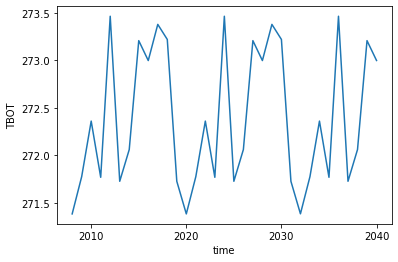

In [14]:
snow = dsCLM.TBOT.resample(time='AS').mean()
snow.plot() ;   #daily snow depth
dsCLM

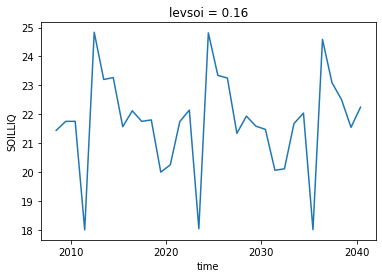

In [9]:
# Changes in Summer soil moisture * 
(dsCLM.SOILLIQ.isel(levsoi=3).resample(time='QS-DEC').mean()[2::4]).plot() ;

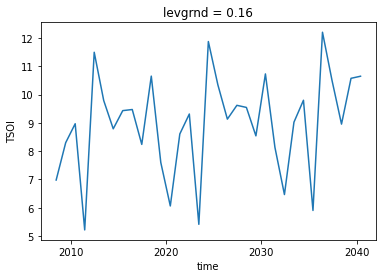

In [10]:
# Changes in Summer soil temperature * 
(dsCLM.TSOI.isel(levgrnd=3).resample(time='QS-DEC').mean()[2::4]-273.15).plot() ;

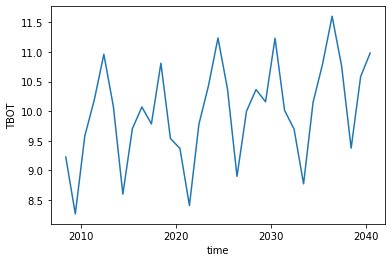

In [11]:
# Average summer temperatures
(dsCLM.TBOT.resample(time="QS-DEC").mean()[2::4]-273.15).plot()

In [12]:
# calculate daily means, mask out non-growing season & calculate rolling mean
# super slow when we compute
# no GPP before May 15 & growing season ends Sept 30 (DOY = 135, 273)

temp = dsCLM[['SNOW_DEPTH','TBOT']].resample(time='D').mean().compute()   #daily fluxes
print(temp)

<xarray.Dataset>
Dimensions:     (time: 12045)
Coordinates:
  * time        (time) object 2008-01-01 00:00:00 ... 2040-12-31 00:00:00
Data variables:
    SNOW_DEPTH  (time) float32 0.4979 0.4976 0.4967 ... 0.6436 0.6523 0.6575
    TBOT        (time) float32 252.6 268.7 270.3 267.1 ... 262.6 268.0 265.8


<Figure size 432x288 with 0 Axes>

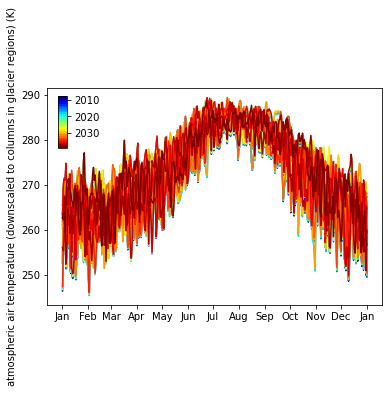

CPU times: user 1.01 s, sys: 30.2 ms, total: 1.04 s
Wall time: 1.02 s


In [17]:
%%time
# Now make the plot
plt.figure(figsize=[6,4])
years = range(2008,2040,1)
nyear = len(years)
fig, ax = plt.subplots()
color = iter(cm.jet(np.linspace(0,1,nyear)))
for i in range(nyear):
    c = next(color)
    y = temp.TBOT.where(temp['time.year'] == years[i])
    ax.plot(y['time.dayofyear'], y,c=c)

months = mdates.MonthLocator()  # every month   
fmt = mdates.DateFormatter('%b')
ax.xaxis.set_major_locator(months)
ax.xaxis.set_major_formatter(fmt)
ax.set_ylabel(dsCLM.TBOT.attrs['long_name']+' (K)')

nvalues=nyear
cmap, norm = mcolors.from_levels_and_colors(years, cm.jet(np.linspace(0,1,(nyear-1))))
sm = cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])

#Specifying figure coordinates works fine:
fig_coord = [0.15,0.67,0.02,0.18]
cbar_ax = fig.add_axes(fig_coord)

# tick mark levels
clevs = [2010,2020,2030,2040]

fig.colorbar(sm,cax=cbar_ax,
             orientation='vertical', 
             ticks=clevs).ax.invert_yaxis() ;

plt.show() ;

<Figure size 432x288 with 0 Axes>

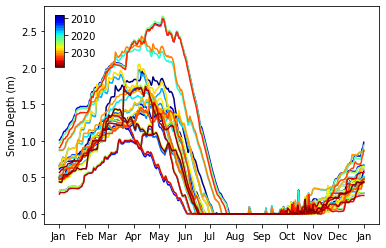

CPU times: user 979 ms, sys: 35.9 ms, total: 1.01 s
Wall time: 1 s


In [18]:
%%time
# Now make the plot
plt.figure(figsize=[6,4])
fig, ax = plt.subplots()

color = iter(cm.jet(np.linspace(0,1,nyear)))
for i in range(nyear):
    c = next(color)
    y = temp.SNOW_DEPTH.where(temp['time.year'] == years[i])
    ax.plot(y['time.dayofyear'], y,c=c)

months = mdates.MonthLocator()  # every month   
fmt = mdates.DateFormatter('%b')
ax.xaxis.set_major_locator(months)
ax.xaxis.set_major_formatter(fmt)
ax.set_ylabel('Snow Depth (m)')

nvalues=nyear
cmap, norm = mcolors.from_levels_and_colors(years, cm.jet(np.linspace(0,1,(nyear-1))))
sm = cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])

#Specifying figure coordinates works fine:
fig_coord = [0.15,0.67,0.02,0.18]
cbar_ax = fig.add_axes(fig_coord)

# tick mark levels
clevs = [2010,2020,2030,2040]

fig.colorbar(sm,cax=cbar_ax,
             orientation='vertical', 
             ticks=clevs).ax.invert_yaxis() ;

plt.show() ;


<xarray.DataArray 'dayofyear' (time: 33)>
array([186, 172, 177, 205, 154, 159, 176, 167, 174, 181, 165, 187, 196,
       171, 177, 204, 158, 159, 176, 170, 175, 181, 166, 187, 196, 171,
       177, 202, 158, 161, 172, 167, 172])
Coordinates:
  * time     (time) object 2008-01-01 00:00:00 ... 2040-01-01 00:00:00


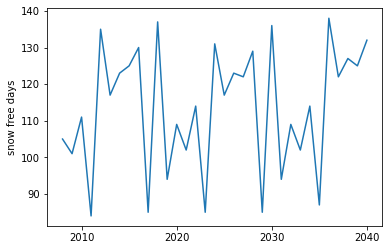

In [19]:
noSNOW = temp.time.dt.dayofyear.where(temp.SNOW_DEPTH<=0) #\
noSNOW
FirstSnowFree = noSNOW.resample(time='AS').min('time',skipna=True).astype('int')
LastSnowFree = noSNOW.resample(time='AS').max('time',skipna=True).astype('int')
SnowFree = (LastSnowFree - FirstSnowFree).astype('int')
SnowFree.attrs['long_name'] = 'number snow free days'
print(FirstSnowFree)
plt.plot(SnowFree.time, SnowFree)
plt.ylabel('snow free days');

In [20]:
import pandas as pd
import numpy as np

nwtOBS = '/glade/p/cgd/tss/people/wwieder/inputdata/single_point/datmdata_NWT_Tvan/NWT_lter_obs_downloads/'
#dsNET = pd.read_table(nwtOBS+'sensor_network_soil_data_30_min.txt')#.to_xarray()  # Saddle sensors
#dsTVan = pd.read_table(nwtOBS+'tvan_soil_data_30_min.txt') # Tvan soil sensors
dsSNO = pd.read_table(nwtOBS+'saddle_grid_snow_depth_data_biweekly.txt') # Saddle snow 

In [21]:
# add date-time
#dsNET.date = pd.to_datetime(dsNET.date)
#dsTVan.date = pd.to_datetime(dsTVan.date)
dsSNO.date = pd.to_datetime(dsSNO.date)
#dsNPP.data = pd.to_datetime(dsNPP.date)

In [22]:
# Aggregate data by date & vegetation community 
# This is already done for snowdepth
#dsSOIgroup = dsSOI.groupby(['date','veg_com'])
#dsSOIdaily = dsSOIgroup.aggregate(np.mean)
#dsSOIdailySTD = dsSOIgroup.aggregate(np.std)

# This is already done for snowdepth, but now we'll get results dimensioned by date*veg_com
dsSNOgroup = dsSNO.groupby(['date','veg_com'])
dsSNOdaily = dsSNOgroup.aggregate(np.mean)

#dsNPPgroup = dsNPP.groupby(['year','veg_com'])
#dsNPPdaily = dsNPPgroup.aggregate(np.mean)
#dsNPPdailySTD = dsNPPgroup.aggregate(np.std)

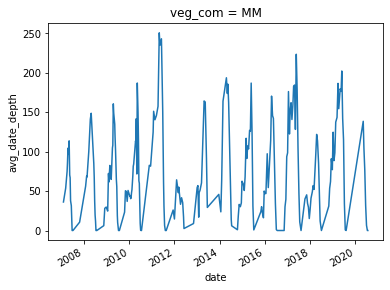

In [23]:
#dsSOI = dsSOIdaily.to_xarray()
#dsSOIstd = dsSOIdailySTD.to_xarray()
dsSNO = dsSNOdaily.to_xarray()
#dsNPP = dsNPPdaily.to_xarray()
#dsNPPstd = dsNPPdailySTD.to_xarray()

# reindex by veg community for plotting consistency
Veg = ["FF", "DM", "MM",'WM','SB']
fullVeg = ["fell_field", "dry_meadow", "moist_meadow",'wet_meadow','snowbed']
#dsSOI = dsSOI.reindex({'veg_com': Veg})
#dsSOIstd = dsSOIstd.reindex({'veg_com': Veg})
dsSNO = dsSNO.reindex({'veg_com': Veg})
#dsNPP = dsNPP.reindex({'veg_com': Veg})
#dsNPPstd = dsNPPstd.reindex({'veg_com': Veg})
dsSNO.sel(veg_com='MM').avg_date_depth.plot() ;
#dsCLM = dsCLM.reindex({'veg': fullVeg})

Text(0, 0.5, 'Snow Depth (cm)')

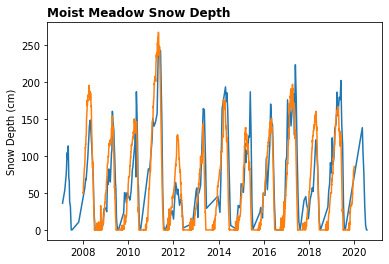

/glade/u/home/wwieder/miniconda3/envs/lens-py/lib/python3.7/site-packages/dask_jobqueue/core.py:360: FutureWarning: ignoring was deprecated in version 2021.06.1 and will be removed in a future release. Please use contextlib.suppress from the standard library instead.
  with ignoring(RuntimeError):  # deleting job when job already gone
/glade/u/home/wwieder/miniconda3/envs/lens-py/lib/python3.7/site-packages/dask_jobqueue/core.py:360: FutureWarning: ignoring was deprecated in version 2021.06.1 and will be removed in a future release. Please use contextlib.suppress from the standard library instead.
  with ignoring(RuntimeError):  # deleting job when job already gone
/glade/u/home/wwieder/miniconda3/envs/lens-py/lib/python3.7/site-packages/dask_jobqueue/core.py:360: FutureWarning: ignoring was deprecated in version 2021.06.1 and will be removed in a future release. Please use contextlib.suppress from the standard library instead.
  with ignoring(RuntimeError):  # deleting job when job al

In [59]:
plotCLM = temp.where(temp['time.year']<2020)
x = plotCLM.isel(time=slice(0,(365*12))).indexes['time'].to_datetimeindex()
y = plotCLM.SNOW_DEPTH.isel(time=slice(0,(365*12)))*100
plt.plot(dsSNO.date,dsSNO.sel(veg_com='MM').avg_date_depth)
plt.plot(x,y)
plt.title('Moist Meadow Snow Depth', loc='left', fontsize='large', fontweight='bold');
plt.ylabel('Snow Depth (cm)')
#print(plotCLM.time)
#print(dsSNO.date.dt.strftime("%Y%m%d"))
#print(plotCLM.indexes['time'].to_datetimeindex())

<xarray.Dataset>
Dimensions:         (date: 242, veg_com: 5)
Coordinates:
  * veg_com         (veg_com) <U2 'FF' 'DM' 'MM' 'WM' 'SB'
  * date            (date) datetime64[ns] 2007-02-06 2007-03-14 ... 2020-07-21
Data variables:
    DoY             (date, veg_com) int64 37 37 37 37 37 ... 203 203 203 203 203
    Year            (date, veg_com) int64 2007 2007 2007 2007 ... 2020 2020 2020
    avg_date_depth  (date, veg_com) float64 3.75 4.688 36.15 4.0 ... 0.0 0.0 0.0
    sd_date_depth   (date, veg_com) float64 10.61 17.46 42.43 ... 0.0 0.0 0.0

## First compare LAI and GPP from two simulations

gC/m^2/s


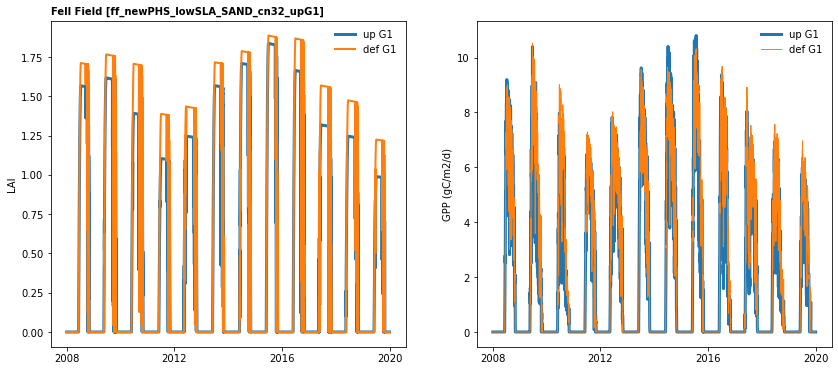

In [5]:
s2d = 60 * 60 *24
plt.figure(figsize=[14,6])
plt.subplot(1,2,1)
plt.plot(dsCLM.time, dsCLM.ELAI, lw=3)
plt.plot(dsCLM2.time, dsCLM2.ELAI, lw=2)
plt.legend(['up G1','def G1'],frameon=False,fontsize='medium',loc='upper right')
plt.title('Fell Field ['+site[0]+']', loc='left', fontsize='medium', fontweight='bold');
plt.ylabel('LAI')        

print(dsCLM.GPP.attrs['units'])
plt.subplot(1,2,2)
plt.plot(dsCLM.time.resample(time='1D').mean(), 
         (dsCLM.GPP.resample(time='1D').mean()*3600*24), 
         lw=3)
plt.plot(dsCLM2.time.resample(time='1D').mean(), 
         (dsCLM2.GPP.resample(time='1D').mean()*3600*24), 
         lw=1)
plt.legend(['up G1','def G1'],frameon=False,fontsize='medium',loc='upper right')
#plt.title('Fell Field ['+site[0]+']', loc='left', fontsize='medium', fontweight='bold');
plt.ylabel('GPP (gC/m2/d)');

In [6]:
# annual GPP
# Warning, observed GPP data has lots of missing values
s2y = 60 * 60 * 24 * 365 #convert seconds / year
print(dsOBS.GPP.attrs['units'])
annGPPobs = (dsOBS.GPP.groupby('time.year').mean()*s2y*12e-6)
annGPP_1 = (dsCLM.GPP.resample(time='1Y').mean()*s2y)
annNPP_1 = (dsCLM.NPP.resample(time='1Y').mean()*s2y)
annAR_1 = (dsCLM.AR.resample(time='1Y').mean()*s2y)
annGPP_2 = (dsCLM2.GPP.resample(time='1Y').mean()*s2y)
annNPP_2 = (dsCLM2.NPP.resample(time='1Y').mean()*s2y)
print('obs GPP  = '+ str(np.round(annGPPobs.mean().values,1))+' +/- '+
      str(np.round(annGPPobs.std().values,1)) +' gC/m2/y')
print('up G1 GPP  = '+ str(np.round(annGPP_1.mean().values,1))+' +/- '+
      str(np.round(annGPP_1.std().values,1)) +' gC/m2/y')
print('def G1 GPP = '+str(np.round(annGPP_2.mean().values, 1))+' +/- '+
      str(np.round(annGPP_2.std().values,1)) +' gC/m2/y')
print('')
print('up G1 NPP  = '+ str(np.round(annNPP_1.mean().values,1))+' +/- '+
      str(np.round(annNPP_1.std().values,1)) +' gC/m2/y')
print('def G1 NPP  = '+ str(np.round(annNPP_2.mean().values,1))+' +/- '+
      str(np.round(annNPP_1.std().values,1)) +' gC/m2/y')
print('up G1 AR  = '+ str(np.round(annAR_1.mean().values,1))+' +/- '+
      str(np.round(annAR_1.std().values,1)) +' gC/m2/y')


umolm-2s-1
obs GPP  = 227.5 +/- 194.8 gC/m2/y
up G1 GPP  = 639.9 +/- 235.8 gC/m2/y
def G1 GPP = 733.2 +/- 244.2 gC/m2/y

up G1 NPP  = 364.9 +/- 157.8 gC/m2/y
def G1 NPP  = 418.7 +/- 157.8 gC/m2/y
up G1 AR  = 275.0 +/- 98.7 gC/m2/y


----------------
### Generate ways to average data
- this may be better using resample, rather than groupby, as below

In [7]:
# create new variables to subset data
print(dsCLMmon.SOILC_vr)
dsOBS['year']  = dsOBS['time.year']
dsOBS['month']  = dsOBS['time.month']
dsCLM['year']  = dsCLM['time.year']
dsCLM['month']  = dsCLM['time.month']
dsOBS['season'] = dsOBS['time.season']
dsCLM['season'] = dsCLM['time.season']
#Can't groupby hour & minutes, so combine them here
dsOBS['HourMin'] = np.round(dsOBS['time.hour'] + dsOBS['time.minute']/60,1)
dsCLM['HourMin'] = np.round(dsCLM['time.hour'] + dsCLM['time.minute']/60,1)
dsOBS['MonDay'] = np.round(dsOBS['time.month'] + dsOBS['time.day']/100,2)
dsCLM['MonDay'] = np.round(dsCLM['time.month'] + dsCLM['time.day']/100,2)

# calculate Rnet from absorbed - reflected radiation
dsCLM['Rnet'] = dsCLM.FSA - dsCLM.FIRA	
dsCLM['Rnet'].attrs['units'] = dsCLM.FSA.attrs['units']
dsCLM['Rnet'].attrs['long_name'] = 'net radiation'

#  total preciptiation
dsCLM['ppt'] = dsCLM.RAIN + dsCLM.SNOW
dsCLM['ppt'].attrs['units'] = dsCLM.RAIN.attrs['units']
dsCLM['ppt'].attrs['long_name'] = 'RAIN + SNOW'

<xarray.DataArray 'SOILC_vr' (levsoi: 20)>
dask.array<getitem, shape=(20,), dtype=float32, chunksize=(20,), chunktype=numpy.ndarray>
Coordinates:
    time     object 2009-01-16 12:00:00
Dimensions without coordinates: levsoi
Attributes:
    long_name:     SOIL C (vertically resolved)
    units:         gC/m^3
    cell_methods:  time: mean


In [8]:
# convert obs GPP units from umol/m2/s to g/m2/h
# assumes NEON results are umolC (not CO2) m^-2 s^-1
dsOBS['GPP'] = dsOBS.GPP * 1e-6 * 12.01 * 3600
dsOBS['GPP'].attrs['units'] = 'gC/m2/h'
# convert clm GPP units from g/m2/s to g/m2/h
dsCLM['GPP'] = dsCLM.GPP * 3600
dsCLM2['GPP'] = dsCLM2.GPP * 3600
dsCLM['GPP'].attrs['units'] = 'gC/m2/h'
dsCLM2['GPP'].attrs['units'] = 'gC/m2/h'

--------------------------
## Plots of seasonal data
--------------------------

In [9]:
Var = ['Rnet','FSH','EFLX_LH_TOT','GPP']
Season = ['DJF','MAM','JJA','SON']

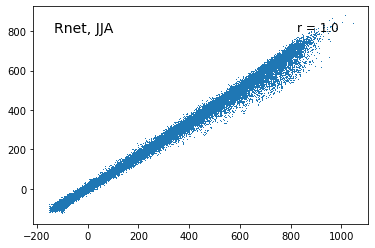

In [10]:
# First make a test for one season and variable
fig, ax = plt.subplots()
x, y = dsOBS[Var[0]].where(dsOBS.season==Season[2]).values,  \
    dsCLM[Var[0]].where(dsCLM.season==Season[2]).values

ax.plot(x, y,',')
line = mlines.Line2D([x.min(), x.max()], [x.min(), x.max()], color='k')
ax.add_line(line)
ax.text(0.15, 0.90,(Var[0]+', '+Season[2]), fontsize=14, 
        ha='center', va='center', transform=plt.gca().transAxes);

# drop missing values from x,y
bad = ~np.logical_or(np.isnan(x), np.isnan(y))
x = np.compress(bad, x)  
y = np.compress(bad, y) 

R, p = stats.pearsonr(x,y)
R = np.round(R, 2)
ax.text(0.85, 0.90,'r = '+str(R),fontsize=12, 
        ha='center', va='center', transform=plt.gca().transAxes);

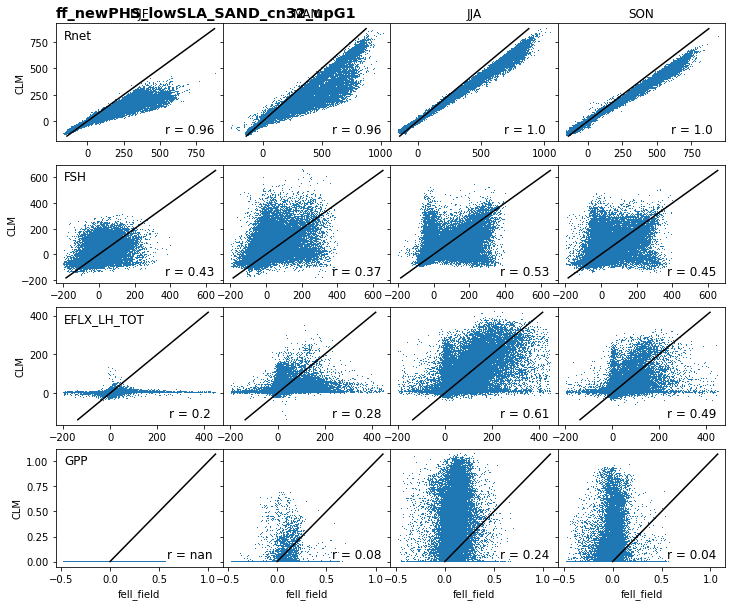

In [11]:
fig, axs = plt.subplots(len(Season), len(Var), sharey='row', #sharey='col',
                        gridspec_kw={'wspace': 0},
                        figsize=(12,10))
for v in range(len(Var)):
    ymin = dsCLM[Var[v]].min()
    ymax = dsCLM[Var[v]].max()
    for i in range(len(Season)):
        x = dsOBS[Var[v]].where(dsOBS.season==Season[i]).values
        y = dsCLM[Var[v]].where(dsCLM.season==Season[i]).values
        axs[v,i].plot(x, y,',')
        line = mlines.Line2D([ymin, ymax], [ymin, ymax], color='k')
        axs[v,i].add_line(line)

        # add stats
        bad = ~np.logical_or(np.isnan(x), np.isnan(y))
        x = np.compress(bad, x)  
        y = np.compress(bad, y) 
        R, p = stats.pearsonr(x,y)
        R = np.round(R, 2)
        axs[v,i].text(0.8, 0.1,'r = '+str(R),fontsize=12, 
                     ha='center', va='center', transform=axs[v,i].transAxes)

        # control titles & axis labels
        # label colums of data with variables name
        if v == 0: 
            axs[v, i].set_title(Season[i])
            #axs[v,i].text(0.15, 0.90,(Season[i]), fontsize=12, ha='center', va='center', 
            #    transform=axs[v,i].transAxes)
            if i == 0:
                axs[i, v].set_title(site[0], loc='left', 
                                    fontsize='x-large', fontweight='bold')

        # x-axis lables on bottom row of plots
        if v == 3: 
            axs[v, i].set_xlabel(longSite)
        
        # y axis labels and seasons in left column
        if i == 0:
            axs[v,i].set_ylabel('CLM')
            axs[v,i].text(0.05, 0.90,(Var[v]), fontsize=12, ha='left', va='center', 
                transform=axs[v,i].transAxes)

plt.savefig(OUTdir+site[0]+'_FluxScatter.pdf');

---------------
## Diel cycle

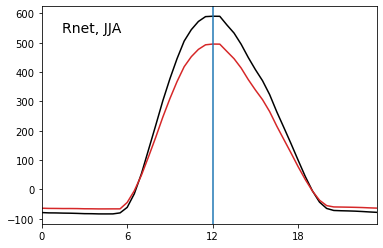

In [12]:
# quick look at one season, variable
v, i = 0, 2
obsX = dsOBS[Var[v]].where(dsOBS.season==Season[i]).groupby(dsOBS['HourMin']).mean().roll(HourMin=rollHour, roll_coords=False)
clmX = dsCLM[Var[v]].where(dsCLM.season==Season[i]).groupby(dsOBS['HourMin']).mean().roll(HourMin=rollHour, roll_coords=False)
obsSD = dsOBS[Var[v]].where(dsOBS.season==Season[i]).groupby(dsOBS['HourMin']).std().roll(HourMin=rollHour, roll_coords=False)
clmSD = dsCLM[Var[v]].where(dsCLM.season==Season[i]).groupby(dsOBS['HourMin']).std().roll(HourMin=rollHour, roll_coords=False)

fig, ax = plt.subplots()
ax.plot(obsX.HourMin, obsX, '-', color='k')
#ax.fill_between(obsX.HourMin, obsX - obsSD, obsX + obsSD, alpha=0.2,color='k')
ax.plot(clmX.HourMin, clmX, '-',color='tab:red')
#ax.fill_between(clmX.HourMin, clmX - clmSD, clmX + clmSD, alpha=0.2,color='tab:red')
ax.text(0.15, 0.90,(Var[v]+', '+Season[i]), fontsize=14, 
        ha='center', va='center', transform=plt.gca().transAxes);
ax.axvline(x=12)
plt.xlim(0,23.5)
plt.xticks(np.arange(0., 24., 6.0));

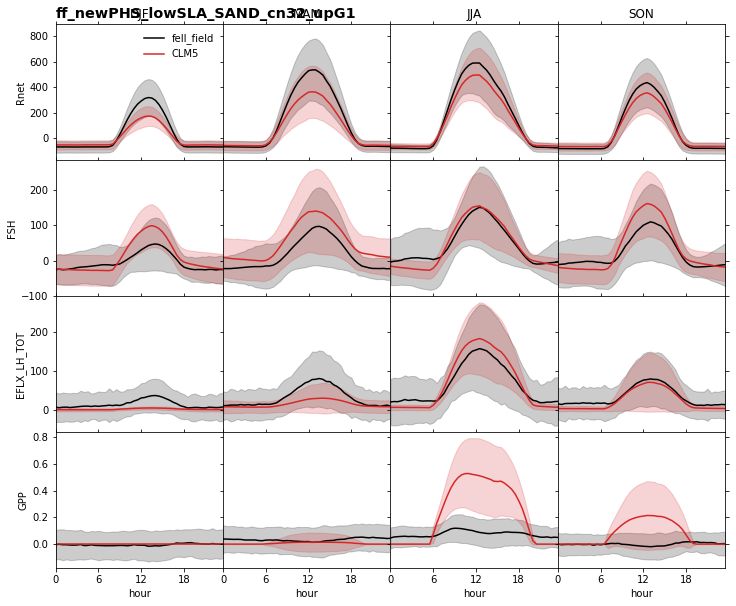

In [13]:
# This is really slow, not sure why.
fig, axs = plt.subplots(len(Var), len(Season), 
                        sharey='row', sharex=True,
                        gridspec_kw={'wspace': 0, 'hspace': 0},
                        figsize=(12,10))
for v in range(len(Var)):
    xmin = dsOBS[Var[v]].min()
    xmax = dsOBS[Var[v]].max()
    for i in range(len(Season)):
        # maybe use resample, not grouby, 
        # eg da.resample(time='1D').mean()
        obsX = dsOBS[Var[v]].where(dsOBS.season==Season[i]).groupby(dsOBS['HourMin']).mean().roll(HourMin=rollHour, roll_coords=False)
        clmX = dsCLM[Var[v]].where(dsCLM.season==Season[i]).groupby(dsOBS['HourMin']).mean().roll(HourMin=rollHour, roll_coords=False)
        obsSD = dsOBS[Var[v]].where(dsOBS.season==Season[i]).groupby(dsOBS['HourMin']).std().roll(HourMin=rollHour, roll_coords=False)
        clmSD = dsCLM[Var[v]].where(dsCLM.season==Season[i]).groupby(dsOBS['HourMin']).std().roll(HourMin=rollHour, roll_coords=False)

        axs[v,i].plot(obsX.HourMin, obsX, '-', color='k')
        axs[v,i].fill_between(obsX.HourMin, obsX - obsSD, obsX + obsSD, alpha=0.2,color='k')
        axs[v,i].plot(clmX.HourMin, clmX, '-',color='tab:red')
        axs[v,i].fill_between(clmX.HourMin, clmX - clmSD, clmX + clmSD, alpha=0.2,color='tab:red')
        axs[v,i].yaxis.set_ticks_position('both')# Ticks on all 4 sides                                                                                                                                                                                                                                    
        axs[v,i].xaxis.set_ticks_position('both')     

        # control titles & axis labels
        # label colums of data with variables name
        if v == 0: 
            axs[v, i].set_title(Season[i])
            if i == 0:
                axs[v,i].legend([longSite,'CLM5'], frameon=False)
                axs[v,i].set_title(site[0], loc='left', 
                                    fontsize='x-large', fontweight='bold')

        # x-axis lables on bottom row of plots
        if v == 3: 
            axs[v, i].set_xlabel('hour')
        
        # y axis labels and seasons in left column
        if i == 0:
            axs[v,i].set_ylabel(Var[v]) 

plt.xlim(0,23.5)
plt.xticks(np.arange(0., 24., 6.0))
#axs[0,0].legend((network+' '+longSite),'CLM5', frameon=False)

plt.savefig(OUTdir+site[0]+'_FluxDiel.pdf');

### Plot mean annual cycle

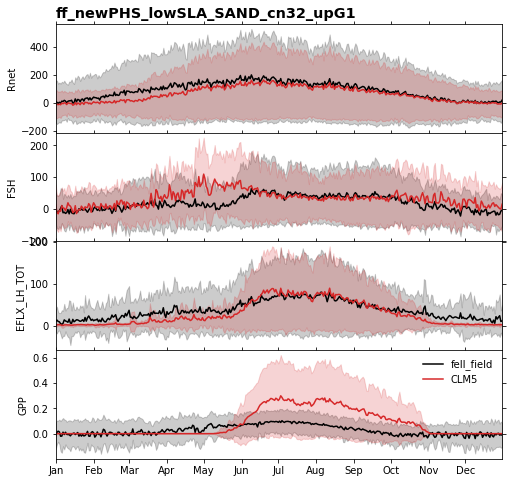

In [14]:
months = mdates.MonthLocator()  # every month
months_fmt = mdates.DateFormatter('%b')

fig, axs = plt.subplots(len(Var),1, sharex=True,
                        gridspec_kw={'wspace': 0, 'hspace': 0},
                        figsize=(8,8))
for v in range(len(Var)):
    # using groupby('time.dayofyear') gives too many days in leap year
    # use variable MonDay  instead
    x = dsOBS['time'].groupby(dsOBS.MonDay).min()
    obsX = dsOBS[Var[v]].groupby(dsOBS.MonDay).mean()
    clmX = dsCLM[Var[v]].groupby(dsOBS.MonDay).mean()
    obsSD = dsOBS[Var[v]].groupby(dsOBS.MonDay).std()
    clmSD = dsCLM[Var[v]].groupby(dsOBS.MonDay).std()
        
    axs[v].plot(x, obsX, '-', color='k')
    axs[v].fill_between(x, obsX - obsSD, obsX + obsSD, alpha=0.2,color='k')
    axs[v].plot(x, clmX, '-',color='tab:red')
    axs[v].fill_between(x, clmX - clmSD, clmX + clmSD, alpha=0.2,color='tab:red')
    axs[v].set_ylabel(Var[v])       
    axs[v].yaxis.set_ticks_position('both')# Ticks on all 4 sides                                                                                                                                                                                                                                    
    axs[v].xaxis.set_ticks_position('both')     

    # set  x axis limits
    axs[v].format_xdata = mdates.DateFormatter('%Y-%m-%d')
    axs[v].xaxis.set_major_locator(months)
    axs[v].xaxis.set_major_formatter(months_fmt)
    datemin = np.datetime64(x[0].values, 'm')
    datemax = np.datetime64(x[-1].values, 'm') 
    axs[v].set_xlim(datemin, datemax)

    # control titles & axis labels
    if v == 0: 
        axs[v].set_title(site[0], loc='left', fontsize='x-large', fontweight='bold')

plt.legend([longSite,'CLM5'], frameon=False)

#fig.autofmt_xdate()
plt.savefig(OUTdir+site[0]+'_FluxAnnual.pdf');

In [15]:
print(OUTdir)

/glade/p/cgd/tss/people/wwieder/inputdata/single_point/datmdata_NWT_Tvan/fell_field/


--------------------------
## Plot depth-time plots of soil moisture and temperature
--------------------------

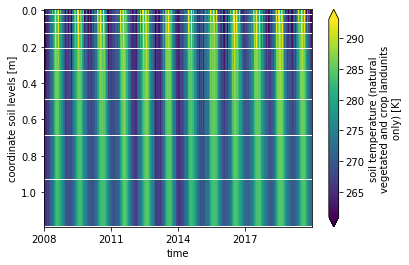

In [16]:
dsCLM.TSOI.isel(levgrnd=(slice(0,9))).plot(x="time",yincrease=False, robust=True);

In [17]:
dsCLM["levgrnd"].isel(levgrnd=slice(0,20)).values

array([0.01, 0.04, 0.09, 0.16, 0.26, 0.4 , 0.58, 0.8 , 1.06, 1.36, 1.7 ,
       2.08, 2.5 , 2.99, 3.58, 4.27, 5.06, 5.95, 6.94, 8.03],
      dtype=float32)

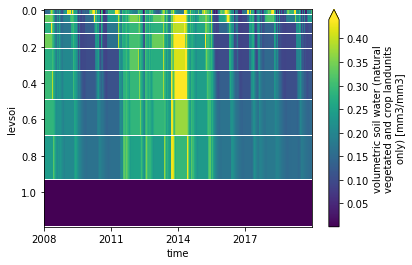

In [18]:
temp = dsCLM['H2OSOI'].copy(deep=True)
temp = temp.assign_coords({"levsoi": dsCLM["levgrnd"].isel(levgrnd=slice(0,20)).values})
#dsCLM.H2OSOI.levsoi  =  dsCLM["levgrnd"].isel(levgrnd=slice(0,20)).values
temp.isel(levsoi=(slice(0,9))).plot(x="time",yincrease=False, robust=True);

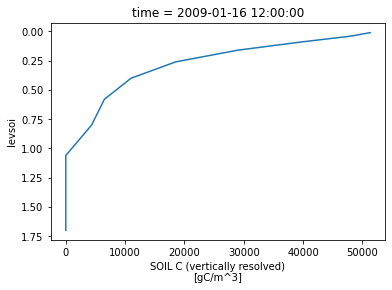

In [19]:
temp = dsCLMmon.SOILC_vr.copy(deep=True)
temp = temp.assign_coords({"levsoi": dsCLM["levgrnd"].isel(levgrnd=slice(0,20)).values})
temp.isel(levsoi=(slice(0,11))).plot(y='levsoi',yincrease=False);


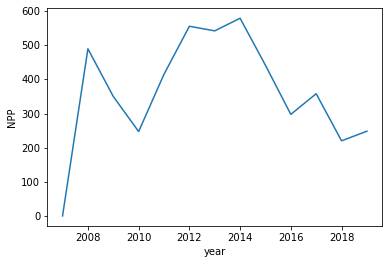

In [20]:
annPPT = dsCLM['ppt'].groupby(dsCLM['year']).mean()
annPPT = annPPT * 3600 * 24 * 365 / 10  #convert mm/s to cm/y
annNPP = dsCLM['NPP'].groupby(dsCLM['year']).mean()
annNPP = annNPP * 3600 * 24 * 365  #convert gC/m2/s gC/m2/y
annNPP.plot();

In [21]:
%%time 
#dsCLM_day = dsCLM.resample(time='1D').mean()
#dsCLM2_day = dsCLM2.resample(time='1D').mean()

CPU times: user 2 µs, sys: 1e+03 ns, total: 3 µs
Wall time: 6.91 µs


gC/m2/h


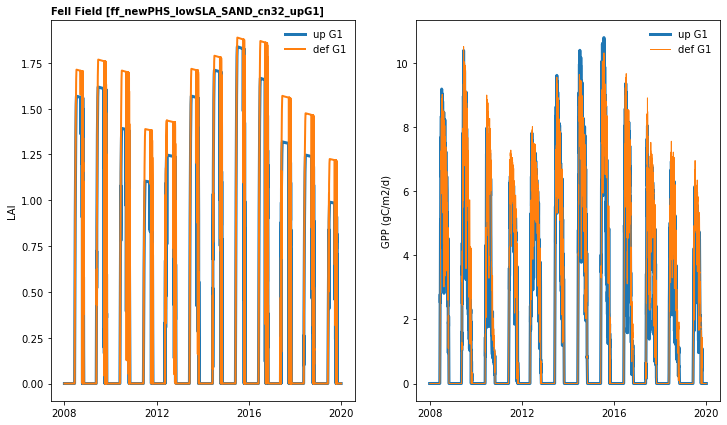

In [22]:
s2d = 60 * 60 *24
plt.figure(figsize=[12,7])
plt.subplot(1,2,1)
plt.plot(dsCLM.time, dsCLM.ELAI, lw=3)
plt.plot(dsCLM2.time, dsCLM2.ELAI, lw=2)
plt.legend(['up G1','def G1'],frameon=False,fontsize='medium',loc='upper right')
plt.title('Fell Field ['+site[0]+']', loc='left', fontsize='medium', fontweight='bold');
plt.ylabel('LAI')        

print(dsCLM.GPP.attrs['units'])
plt.subplot(1,2,2)
plt.plot(dsCLM.time.resample(time='1D').mean(), 
         dsCLM.GPP.resample(time='1D').mean()*24, 
         lw=3)
plt.plot(dsCLM2.time.resample(time='1D').mean(), 
         dsCLM2.GPP.resample(time='1D').mean()*24, 
         lw=1)
plt.legend(['up G1','def G1'],frameon=False,fontsize='medium',loc='upper right')
#plt.title('Fell Field ['+site[0]+']', loc='left', fontsize='medium', fontweight='bold');
plt.ylabel('GPP (gC/m2/d)');

In [23]:
# annual GPP
# Warning, observed GPP data has lots of missing values
annGPPobs = (dsOBS.GPP.groupby('time.year').mean()*24*365)
annGPP_1 = (dsCLM.GPP.resample(time='1Y').mean()*24*365)
annNPP_1 = (dsCLM.NPP.resample(time='1Y').mean()*3600*24*365)
annAR_1 = (dsCLM.AR.resample(time='1Y').mean()*3600*24*365)
annGPP_2 = (dsCLM2.GPP.resample(time='1Y').mean()*24*365)
annNPP_2 = (dsCLM2.NPP.resample(time='1Y').mean()*3600*24*365)
print('obs GPP  = '+ str(np.round(annGPPobs.mean().values,1))+' +/- '+
      str(np.round(annGPPobs.std().values,1)) +' gC/m2/y')
print('up G1 GPP  = '+ str(np.round(annGPP_1.mean().values,1))+' +/- '+
      str(np.round(annGPP_1.std().values,1)) +' gC/m2/y')
print('def G1 GPP = '+str(np.round(annGPP_2.mean().values, 1))+' +/- '+
      str(np.round(annGPP_2.std().values,1)) +' gC/m2/y')
print('')
print('up G1 NPP  = '+ str(np.round(annNPP_1.mean().values,1))+' +/- '+
      str(np.round(annNPP_1.std().values,1)) +' gC/m2/y')
print('up G2 NPP  = '+ str(np.round(annNPP_2.mean().values,1))+' +/- '+
      str(np.round(annNPP_1.std().values,1)) +' gC/m2/y')
print('up G1 AR  = '+ str(np.round(annAR_1.mean().values,1))+' +/- '+
      str(np.round(annAR_1.std().values,1)) +' gC/m2/y')

obs GPP  = 227.7 +/- 195.0 gC/m2/y
up G1 GPP  = 639.9 +/- 235.8 gC/m2/y
def G1 GPP = 733.2 +/- 244.2 gC/m2/y

up G1 NPP  = 364.9 +/- 157.8 gC/m2/y
up G2 NPP  = 418.7 +/- 157.8 gC/m2/y
up G1 AR  = 275.0 +/- 98.7 gC/m2/y


- GPP is still to high, but 
- Increasing G1 reduces annual GPP flux, but increases IAV
- I'm surprised AR fluxes are not higher... I wonder why, maybe the low C:N used here?

In [24]:
dsCLM.AR

<xarray.DataArray 'AR' (time: 210240)>
dask.array<rechunk-merge, shape=(210240,), dtype=float32, chunksize=(35040,), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 2007-12-31 23:44:59.999993 ... 2019-12-31 23:15:00
Attributes:
    long_name:     autotrophic respiration (MR + GR)
    units:         gC/m^2/s
    cell_methods:  time: mean

## OBS GPP by year

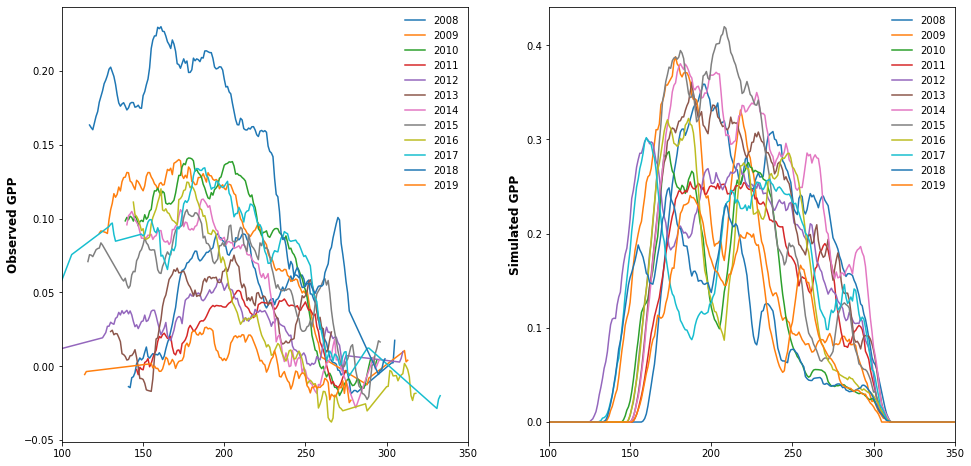

In [25]:
plt.figure(figsize=[16,8])

# doing this in a loop seems dumb & slow, but it works
for j in range(2):
    plt.subplot(1,2,(j+1))
    plt.xlim((100, 350)) 
    if j == 0: plt.ylabel('Observed GPP', fontsize='large', fontweight='bold')
    else: plt.ylabel('Simulated GPP', fontsize='large', fontweight='bold');

    for i in range(len(years)):
        I = i + 0  #if fewer years are prefered

        #subset year of data
        if j == 0: 
            dsPlot = dsOBS.where(dsOBS['year']==years[I])
        else: 
            dsPlot = dsCLM.where(dsCLM['year']==years[I])

        # daily means
        x = dsPlot['time.dayofyear'].groupby(dsPlot['time.dayofyear']).min()
        y = dsPlot.get('GPP').where(dsPlot['year']==years[I]).groupby(dsPlot['time.dayofyear']).mean().chunk(chunks=1)
        # mask out Daily GPP where TBOT<-4
        if j == 0:
            z = dsPlot.get('TBOT').where(dsPlot['year']==years[I]).groupby(dsPlot['time.dayofyear']).mean()
            y = y.where(z>269)

        #  10 day rolling mean
        y = y.chunk(chunks=10).rolling(dayofyear=10, center=True).mean().dropna("dayofyear")
        plt.plot(y.dayofyear, y, '-')

    plt.legend(years, frameon=False, loc='upper right');

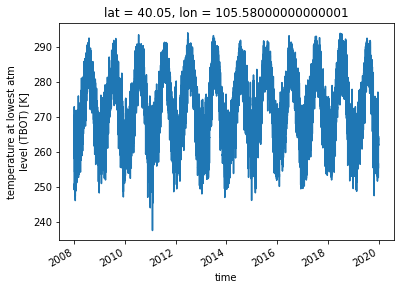

In [26]:
dsOBS['TBOT'].plot()

### Soil moisture by year

range(2007, 2020)
2014
2015
2016
2017


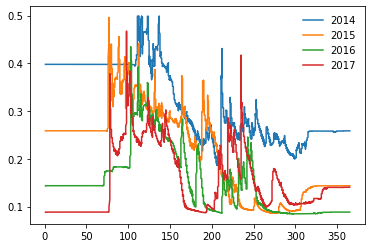

In [27]:
years = range(dsCLM['year'].values.min(), (dsCLM['year'].values.max()+1))
nyear = 4 
print(years)
for i in range(nyear):
    I = i + 7
    print(years[I])
    x = dsCLM['time.dayofyear'].where(dsCLM['year']==years[I])
    y = dsCLM.get('H2OSOI').isel(levsoi=2).where(dsCLM['year']==years[I])
    plt.plot(x, y, '-')

plt.legend(years[7:11], frameon=False, loc='upper right');

-----------------
### look into sources of potential flux errors

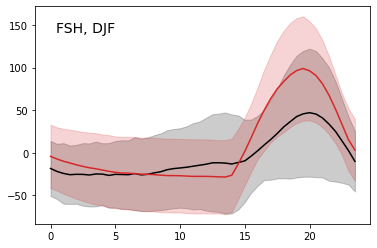

In [28]:
Var = ['FSH','TBOT','FSDS','FLDS']
v = 0
i = 0
obsX = dsOBS[Var[v]].where(dsOBS.season==Season[i]).groupby(dsOBS['HourMin']).mean()
clmX = dsCLM[Var[v]].where(dsCLM.season==Season[i]).groupby(dsOBS['HourMin']).mean()#.roll(HourMin=rollHour, roll_coords=False)
obsSD = dsOBS[Var[v]].where(dsOBS.season==Season[i]).groupby(dsOBS['HourMin']).std()
clmSD = dsCLM[Var[v]].where(dsCLM.season==Season[i]).groupby(dsOBS['HourMin']).std()#.roll(HourMin=rollHour, roll_coords=False)

fig, ax = plt.subplots()
ax.plot(obsX.HourMin, obsX, '-', color='k')
ax.fill_between(obsX.HourMin, obsX - obsSD, obsX + obsSD, alpha=0.2,color='k')
ax.plot(clmX.HourMin, clmX, '-',color='tab:red')
ax.fill_between(clmX.HourMin, clmX - clmSD, clmX + clmSD, alpha=0.2,color='tab:red')
ax.text(0.15, 0.90,(Var[v]+', '+Season[i]), fontsize=14, 
        ha='center', va='center', transform=plt.gca().transAxes);

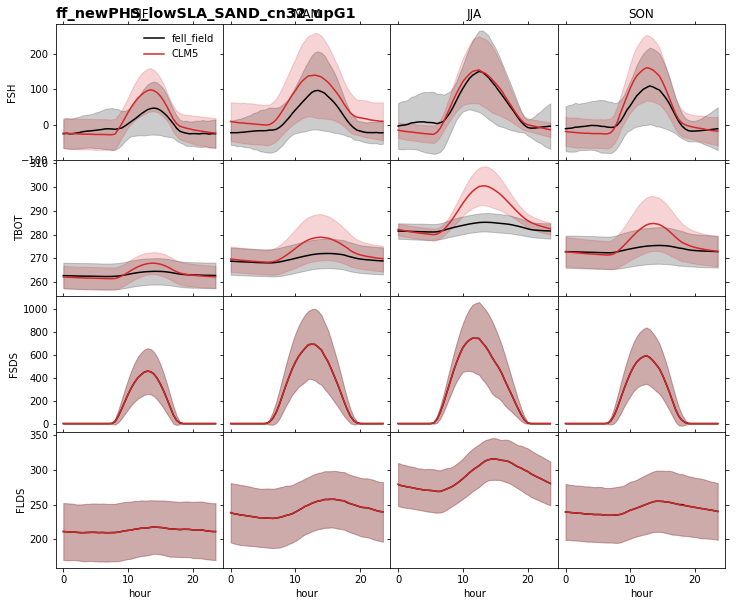

In [29]:
# This is really slow, not sure why.
fig, axs = plt.subplots(len(Var), len(Season), 
                        sharey='row', sharex=True,
                        gridspec_kw={'wspace': 0, 'hspace': 0},
                        figsize=(12,10))
for v in range(len(Var)):
    for i in range(len(Season)):
        obsX = dsOBS[Var[v]].where(dsOBS.season==Season[i]).groupby(dsOBS['HourMin']).mean().roll(HourMin=rollHour, roll_coords=False)
        obsSD = dsOBS[Var[v]].where(dsOBS.season==Season[i]).groupby(dsOBS['HourMin']).std().roll(HourMin=rollHour, roll_coords=False)
        if Var[v]!='TBOT':
            clmX = dsCLM[Var[v]].where(dsCLM.season==Season[i]).groupby(dsOBS['HourMin']).mean().roll(HourMin=rollHour, roll_coords=False)
            clmSD = dsCLM[Var[v]].where(dsCLM.season==Season[i]).groupby(dsOBS['HourMin']).std().roll(HourMin=rollHour, roll_coords=False)
        else:
            clmX = dsCLM['TG'].where(dsCLM.season==Season[i]).groupby(dsOBS['HourMin']).mean().roll(HourMin=rollHour, roll_coords=False)
            clmSD = dsCLM['TG'].where(dsCLM.season==Season[i]).groupby(dsOBS['HourMin']).std().roll(HourMin=rollHour, roll_coords=False)

            
        axs[v,i].plot(obsX.HourMin, obsX, '-', color='k')
        axs[v,i].fill_between(obsX.HourMin, obsX - obsSD, obsX + obsSD, alpha=0.2,color='k')
        axs[v,i].plot(clmX.HourMin, clmX, '-',color='tab:red')
        axs[v,i].fill_between(clmX.HourMin, clmX - clmSD, clmX + clmSD, alpha=0.2,color='tab:red')
        axs[v,i].yaxis.set_ticks_position('both')# Ticks on all 4 sides                                                                                                                                                                                                                                    
        axs[v,i].xaxis.set_ticks_position('both')     

        # control titles & axis labels
        # label colums of data with variables name
        if v == 0: 
            axs[v, i].set_title(Season[i])
            if i == 0:
                axs[v,i].legend([longSite,'CLM5'], frameon=False)
                axs[v,i].set_title(site[0], loc='left', 
                                    fontsize='x-large', fontweight='bold')

        # x-axis lables on bottom row of plots
        if v == 3: 
            axs[v, i].set_xlabel('hour')
        
        # y axis labels and seasons in left column
        if i == 0:
            axs[v,i].set_ylabel(Var[v]) 